In [1]:
import pandas as pd
import json
from evaluation_utils import read_global_results, ssl_method_to_category, unpivot_ssl_model, unpivot_baseline_model, read_processed_shards
from constants import PRELIMINARY_DIR, MODE_1_PROCESSED_DIR, MODE_2_3_MARG_PROCESSED_DIR, TEST_METRIC, ENCODERS, TRAINING_SCHEMES, SSL_MODELS, BASELINES, ENCODER_COLORS, SINGLE_ENCODER_MODELS, \
                        GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL, MODE_1_LEARNING_CURVES_DIR, model_abbreviations
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
import itertools
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import patches
from matplotlib.colors import ListedColormap
from itertools import zip_longest

In [2]:
df = read_processed_shards(MODE_2_3_MARG_PROCESSED_DIR)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
12.ndjson
13.ndjson
14.ndjson
15.ndjson
16.ndjson
17.ndjson
18.ndjson
19.ndjson
20.ndjson
21.ndjson
22.ndjson
23.ndjson
24.ndjson
25.ndjson
26.ndjson
27.ndjson
28.ndjson
29.ndjson
30.ndjson
31.ndjson
32.ndjson
concatenating


In [3]:
# SSL results
df_ssl = unpivot_ssl_model(df=df, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES,  include_graph_params=True)
df_baseline = unpivot_baseline_model(df=df, suffix=TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES, include_graph_params=True)

## Appendix plots
#### For all graph paramters:
- The fixed parameters seems to make the default graphs harder than the graphs sampled for the global results. This is most obvious in the parameters which seem to have little influence on performance, such as cluster_size_slope, where most points on the line is below the results reported in the global results table.
- Comment on baselines for each graph parameter

#### Avg degree:
- Encoders
    - The performance of GCN and GIN gets worse with higher avg degree no matter the training scheme. This is also the case for GAT URL
    - For GAT trained wth JL or PF, most models either maintain their performance or increase it with higher avg degree. GAT generally performs best for higher degrees.
- Training schemes
    - Most models seem to prefer JL or PF in the overall case (as seen in global)
    - There is generally not a big difference in how the avg degree affects the training schemes, but with (GAT, URL) we see that the performance degrades with higher degrees while GAT with JL or PF generally improves the performance 
- Specific methods / categories
    - CFR is an exception here, where it shows strong performance for (URL, GIN) for low degrees. However, even with high degrees GAT takes over.
    - Method that use PPR diffusion on the augmentated graphs are much less affected by the avg degree. This could suggest that topology augmentations that utilize diffusion strategies to add edges may be useful in learning good embeddings when the degrees are low (show MERIT). 
    - MVMI-FT also does not seem to be affected by the avg degree at all

/tmp/ipykernel_19468/3640026819.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


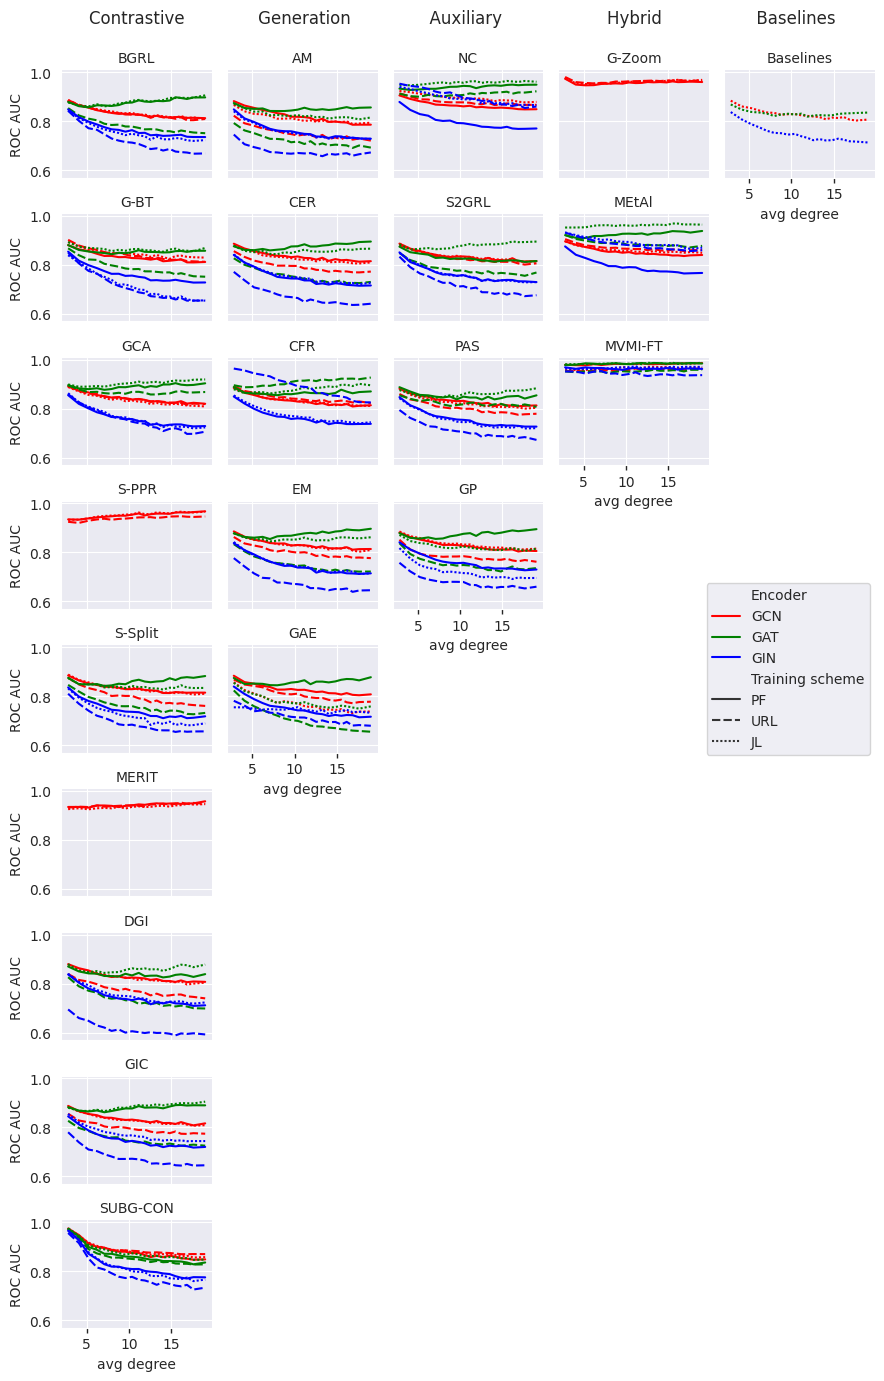

In [43]:
# Construct plotting dataframe
df_baseline['SSL_model'] = "Baselines"
df_baseline['Training_scheme'] = "JL"
df_baseline = df_baseline.rename(columns={"Baseline_model": "Encoder"})
df_plot = pd.concat([df_ssl, df_baseline], ignore_index=True)
df_plot.rename(columns={TEST_METRIC: "ROC AUC"}, inplace=True)
df_plot.rename(columns=lambda x: x.replace('_', ' '), inplace=True)
df_plot['SSL model'] = df_plot['SSL model'].apply(lambda x: x if x == "Baselines" else model_abbreviations[x])

# Styling
markers={'PF':'o', 'URL':'s', 'JL':'X'}
sns.set_style("darkgrid")

# Function to correct the titles made by seaborn
def set_custom_titles(**kwargs):
    title = kwargs['facet'].name.split("=")[-1]
    plt.gca().set_title(title)


# Hack to display the grid of plots such that each column is an SSL category
order = []
rows = len(CONTRAST_ALL)
for (c,g,a,h,b) in zip_longest(CONTRAST_ALL, GENERATION_ALL, AUXILIARY_ALL,  HYBRID_ALL, ["Baselines"], fillvalue="empty"):
    order.append(model_abbreviations.get(c)); order.append(model_abbreviations.get(g)) 
    order.append(model_abbreviations.get(a)); order.append(model_abbreviations.get(h))
    order.append(b)

# Make a plot for each graph parameter
for param, param_group in df_plot.groupby(df_plot['marginal param'].apply(tuple)):
    if len(param) > 1 or param[0] == "min_degree": # Discard two-param marginalization + incorrect configuration for min degree
        continue
    param = param[0].replace("_", " ")
    param_group[param] = pd.qcut(param_group[param], q=20, duplicates='drop').apply(lambda x: x.mid)
    g = sns.relplot(
        data=param_group, x=param, y="ROC AUC",
        col="SSL model", hue="Encoder", style="Training scheme", col_wrap=5, height=1.5, aspect=1.2,
        kind="line", markers=None, dashes=True, errorbar=None, col_order=order, palette=ENCODER_COLORS, 
    )
    g.set_titles("{col_name}") 

    # Correct the xlabel positions based on the empty plots
    xlabel = g.axes[40].get_xlabel()
    xticklabels = g.axes[40].get_xticklabels()
    for i in [4, 13, 17, 21, 40]:
        g.axes[i].set_xlabel(xlabel, visible=True)
        g.axes[i].set_xticklabels(xticklabels, visible=True)
        g.axes[i].tick_params(axis='x', which='both', bottom=True, top=False, width=0)
        g.axes[i].get_xaxis().set_ticks_position('bottom')
        g.axes[i].get_xaxis().set_tick_params(which='both', width=1)

    # Set empty plots invisible
    for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_axis_off()
            ax.set_title("")

    sns.move_legend(g, "upper left", bbox_to_anchor=(.69, .6), frameon=True)
    plt.suptitle("Contrastive              Generation               Auxiliary                    Hybrid                  Baselines", 
                 y=1.02, x = 0.1, horizontalalignment='left')
    plt.show()
    break

## Specific plots for main report

In [69]:
df_ssl2 = df_ssl.copy()

#cmap = ListedColormap(['red', 'green', 'blue'])
markers={'PF':'o', 'URL':'s', 'JL':'X'}

for param, param_group in df_ssl2.groupby(df_ssl2.marginal_param.apply(tuple)):
    if len(param) > 1 or param[0] == "min_degree": # Discard two-param marginalization + incorrect configuration for min_degree
        continue
    print(param[0])
    for ssl_method, ssl_group in param_group.groupby(["SSL_model"]):
        fig, ax = plt.subplots(figsize=(5,4))
        ssl_group[param[0]] = pd.qcut(ssl_group[param[0]], q=20, duplicates='drop').apply(lambda x: x.mid)
        sns.lineplot(data=ssl_group, x=param[0], y=TEST_METRIC, hue='Encoder',
                     style='Training_scheme',  markers=None, dashes=True, errorbar=None, ax=ax, palette=ENCODER_COLORS)
        plt.title(ssl_method)
        plt.ylim(0.5, 1.0)
        plt.grid()
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.show()


avg_degree


/tmp/ipykernel_37296/504520136.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (ssl_method, ssl_group) in enumerate(param_group.groupby(["SSL_model"])):


AttributeError: 'numpy.ndarray' object has no attribute 'yaxis'

Error in callback <function _draw_all_if_interactive at 0x7fc7369c7eb0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fc72301dc60> (for post_execute):


KeyboardInterrupt: 